# Installing packages and downloading pretrained model

In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.5MB 26.3MB/s 
     |████████████████████████████████| 3.3MB 42.5MB/s 
     |████████████████████████████████| 901kB 31.5MB/s 
     |████████████████████████████████| 245kB 28.8MB/s 
     |████████████████████████████████| 122kB 46.2MB/s 
     |████████████████████████████████| 245kB 41.8MB/s 


In [1]:
#import google
from pprint import pprint

import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer
#from datasets import list_datasets, list_metrics, load_dataset, load_metric

torch.set_grad_enabled(False)

In [2]:
# Store the model we want to use
MODEL_NAME = "bert-base-uncased" #@param

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME,
                                  output_hidden_states=True,
                                  output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME 
                                          )

# Loading dataset (disabled for now)

In [ ]:
#model

In [ ]:
#datasets = list_datasets()
#metrics = list_metrics()

# You can access various attributes of the datasets before downloading them
#ptb_dataset = list_datasets(with_details=True)[datasets.index('ptb_text_only')]

#pprint(ptb_dataset.__dict__)  # It's a simple python dataclass

In [ ]:
# Downloading and loading a dataset
#dataset = load_dataset('ptb_text_only', split='validation')
#pprint(dataset.info.__dict__)

In [ ]:
#print(f"👉Dataset len(dataset): {len(dataset)}")
#print("\n👉First item 'dataset[0]':")
#pprint(dataset[0])

# Accessing the hidden states (contextualized embeddings)

In [226]:
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)


def get_hidden_states(encoded, token_ids_word, model, layers):
    """ Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them.""" 
 
    # Get all hidden states
    inputs = encoded['input_ids']
    attention_mask =  encoded['attention_mask']
    output = model(inputs, attention_mask)
    states = output.hidden_states
    # Stack all requested layers
    # Only select the tokens that constitute the requested word 
    word_tokens_output = torch.stack([
            states[i].detach().squeeze()[token_ids_word]
                if i > 0 else
            model.embeddings.word_embeddings(inputs).squeeze()[token_ids_word]
                for i in layers])
    word_tokens_output = word_tokens_output.mean(axis=1)
    
    if len(layers) > 1:
        word_tokens_output = word_tokens_output.sum(axis=0, keepdims=True)
    return word_tokens_output


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
       that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
    return get_hidden_states(encoded, token_ids_word, model, layers)

# Retrieving word representations from separate or combined layers

In [20]:
#sentences = dataset['sentence']
sentences = ['Do not compare apples and oranges and apples and apples and apples and apples','another sentence']

encoded_sentences = tokenizer.batch_encode_plus(sentences, padding='longest')
tokenized_sentences = tokenizer.batch_decode(encoded_sentences['input_ids'])

print('sentence:', sentences[0])
print('tokenized sentence:', tokenized_sentences[0])

sentence: Do not compare apples and oranges and apples and apples and apples and apples
tokenized sentence: [CLS] don't compare apples and oranges and apples and apples and apples and apples [SEP]


In [227]:
vecs = []
#for layer_group in [[-12], [-9], [-5], [-1], [-4,-3,-2,-1],[0]]:
for layer_group in [[1], [4], [8], [12], [9,10,11,12], [0]]:
    vecs.append(
        np.concatenate(
                [
                    get_word_vector(sentences[0], [i], tokenizer, model, layer_group)
                        for i in range(len(sentences[0].split()))
                ]
            )
        )

# Compute and visualize dissimilarity matrices

In [9]:
#@title Import packages
import numpy as np
import pandas as pd
from scipy import stats 
from scipy import corrcoef
from scipy.spatial.distance import cosine, euclidean, pdist, squareform, is_valid_dm, cdist
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from scipy.spatial import distance_matrix
import torch

#Visualization packages
import seaborn as sns
import matplotlib.pylab as plt

In [219]:
distance_matrices = [
    cdist(vec, vec, "euclidean").round(10)
        for vec in vecs
]

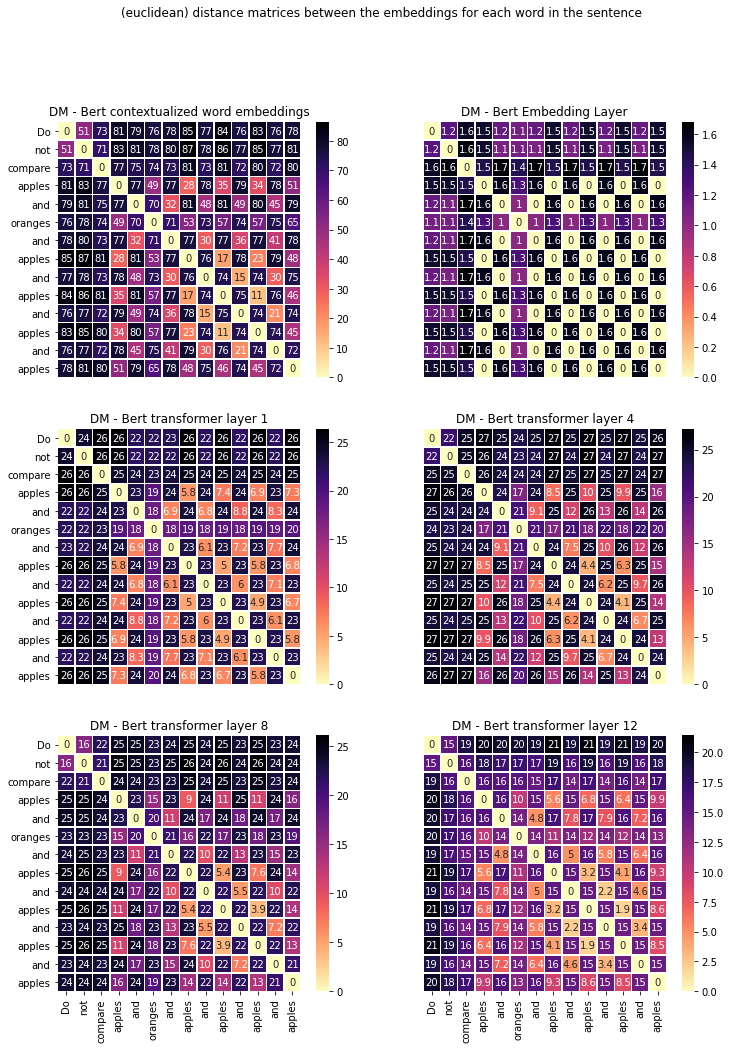

In [232]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16), sharey=True)
fig.suptitle('(euclidean) distance matrices between the embeddings for each word in the sentence')


plt.subplot(3, 2, 1)
ax1 = sns.heatmap(distance_matrices[4], linewidth=0.5, annot = True, cmap = 'magma_r', yticklabels=sentences[0].split())
ax1.set_title('DM - Bert contextualized word embeddings')
ax1.xaxis.set_visible(False)

plt.subplot(3, 2, 2)
ax6 = sns.heatmap(distance_matrices[5], linewidth=0.5, annot = True, cmap = 'magma_r', xticklabels=sentences[0].split(), yticklabels=sentences[0].split())
ax6.set_title('DM - Bert Embedding Layer')
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)

plt.subplot(3, 2, 3)
ax2 = sns.heatmap(distance_matrices[0], linewidth=0.5, annot = True, cmap = 'magma_r', yticklabels=sentences[0].split())
ax2.set_title('DM - Bert transformer layer 1')
ax2.xaxis.set_visible(False)

plt.subplot(3, 2, 4)
ax3 = sns.heatmap(distance_matrices[1], linewidth=0.5, annot = True, cmap = 'magma_r', xticklabels=sentences[0].split(), yticklabels=sentences[0].split())
ax3.set_title('DM - Bert transformer layer 4')
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)

plt.subplot(3, 2, 5)
ax4 = sns.heatmap(distance_matrices[2], linewidth=0.5, annot = True, cmap = 'magma_r', xticklabels=sentences[0].split(), yticklabels=sentences[0].split())
ax4.set_title('DM - Bert transformer layer 8')

plt.subplot(3, 2, 6)
ax5 = sns.heatmap(distance_matrices[3], linewidth=0.5, annot = True, cmap = 'magma_r', xticklabels=sentences[0].split(), yticklabels=sentences[0].split())
ax5.set_title('DM - Bert transformer layer 12')
ax5.yaxis.set_visible(False)

plt.show()


The visualization nicely shows that the 'apples' in the example sentence receive very similar embeddings in layer 1, which are very different from 'oranges' (in fact, the embeddings for 'apples' are of course identical in the input embeddings, but I got an so-far unsolved error when trying to access those). And then the 'apples' at the end behaves differently when we move higher up in the BERT layer, and the difference between the other apples and the oranges become smaller.

Using these DMs, it should be rather straightforward to run the Mantel test, and hopefully also to run this on a larger set of input sentences.